In [1]:
import polars as pl
import polars as pl
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import polars as pl
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pyarrow
import matplotlib.pyplot as plt

In [68]:
df_control_final = pl.read_csv("df_c_final.csv")
df_disease_final = pl.read_csv("df_d_final.csv")
df_drugs = pl.read_csv("Drugs_TF_Targeting_AllSamples.csv")

In [69]:
df_control_final[:, 1:5]

gene,GTEX-111CU-1226-SM-5EGIN,GTEX-111YS-1826-SM-5GIEP,GTEX-1122O-1426-SM-5H11R
str,f64,f64,f64
"""A1BG""",0.064846,2.17557,0.398071
"""A1CF""",-0.38412,0.13588,-0.10258
"""A2M""",-0.988328,-0.923755,-1.100879
"""A4GALT""",-0.464488,-0.606062,-0.753284
"""AAAS""",-0.811409,-1.553712,-0.982726
…,…,…,…
"""ZXDC""",-0.351864,-0.253291,-0.023884
"""ZYG11B""",0.140255,1.060328,0.355958
"""ZYX""",0.529551,-0.163461,0.45298


In [70]:
with open("c2.cp.reactome.v2025.1.Hs.symbols.gmt", "r") as f:
    lines = [line.strip().split("\t") for line in f]

mapping_data = [(gene, line[0]) for line in lines for gene in line[2:]]

df_mapping = pl.DataFrame(mapping_data, schema=["gene", "pathway_name"], orient="row")

df_control_pooled = (
    df_control_final
    .join(df_mapping, on="gene", how="inner")
    .group_by("pathway_name")
    .agg(pl.col(pl.Float64).sum())
)

df_disease_pooled = (
    df_disease_final
    .join(df_mapping, on="gene", how="inner")
    .group_by("pathway_name")
    .agg(pl.col(pl.Float64).sum())
)

In [76]:
df_disease_pooled[:6, :5]

pathway_name,TCGA-AA-3856-01A-01R-0905-07,TCGA-QG-A5YV-01A-11R-A28H-07,TCGA-CM-6172-01A-11R-1653-07,TCGA-AA-3855-01A-01R-1022-07
str,f64,f64,f64,f64
"""REACTOME_BIOSYNTHESIS_OF_MARES…",-139.260246,-248.538161,-68.68866,-173.759721
"""REACTOME_REGULATION_OF_MITF_M_…",1025.864924,3745.497974,1757.668758,1379.22795
"""REACTOME_MITOCHONDRIAL_FATTY_A…",-123.135427,466.913869,1893.059588,-388.560393
"""REACTOME_CARGO_TRAFFICKING_TO_…",3293.591104,5403.797464,7018.205084,2688.067458
"""REACTOME_DISINHIBITION_OF_SNAR…",668.569181,1593.748516,1643.626066,-1232.201889
"""REACTOME_DISSOLUTION_OF_FIBRIN…",-453.924647,78.86434,-2366.579471,171.31461


In [77]:
df_disease_pooled.shape

(1780, 148)

In [ ]:
pdf_control = df_control_pooled.to_pandas().set_index("pathway_name").T
pdf_disease = df_disease_pooled.to_pandas().set_index("pathway_name").T

pdf_control["label"] = 0.0
pdf_disease["label"] = 1.0

df_combined = pd.concat([pdf_control, pdf_disease], axis=0).fillna(0)

X = df_combined.drop(columns=["label"]).values
y = df_combined["label"].values
feature_names = df_combined.drop(columns=["label"]).columns.tolist()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

In [ ]:
class DiagnosticNet(nn.Module):
    def __init__(self, input_dim):
        super(DiagnosticNet, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)

input_dim = X.shape[1]
model = DiagnosticNet(input_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

epochs = 500
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

model.eval()
with torch.no_grad():
    test_acc = ((model(X_test) > 0.5) == y_test).float().mean()
    print(f"Test Accuracy: {test_acc.item():.4f}")

Training Diagnostic Model...
Epoch 0, Loss: 0.6889
Epoch 100, Loss: 0.0002
Epoch 200, Loss: 0.0001
Epoch 300, Loss: 0.0000
Epoch 400, Loss: 0.0000
Test Accuracy: 1.0000


In [ ]:
model_logits = nn.Sequential(*list(model.network.children())[:-1])
model_logits.eval()

disease_indices = np.where(y == 1)[0]
X_disease = torch.tensor(X_scaled[disease_indices], dtype=torch.float32, requires_grad=True)

logits = model_logits(X_disease)
logits.sum().backward()

robust_cure_vector = -X_disease.grad.detach().numpy()
mean_cure_vector = np.mean(robust_cure_vector, axis=0)

print("First 5 values of new vector:", mean_cure_vector[:5])
print("Vector Norm:", np.linalg.norm(mean_cure_vector))

First 5 values of new vector: 

[0.0111378  0.00923177 0.01322777 0.02033135 0.01324436]
Vector Norm: 0.603118


In [9]:
mean_cure_vector

array([0.0111378 , 0.00923177, 0.01322777, ..., 0.00731189, 0.01354014,
       0.01027981], shape=(1780,), dtype=float32)

In [10]:
df_drug_raw = pl.read_csv("TFtargeting_CPC018_A375_6H_BRD-K06817181-001-01-5_10.csv")

drug_weight_col = df_drug_raw.columns[2]

df_drug_pooled = (
    df_drug_raw
    .select([
        pl.col("Row").alias("gene"),
        pl.col(drug_weight_col).alias("weight")
    ])
    .join(df_mapping, on="gene", how="inner")
    .group_by("pathway_name")
    .agg(pl.col("weight").sum())
)

drug_series = df_drug_pooled.to_pandas().set_index("pathway_name")["weight"]
drug_vector_raw = drug_series.reindex(feature_names, fill_value=0.0).values

drug_vector_perturbed = drug_vector_raw / scaler.scale_

score = cosine_similarity(
    drug_vector_perturbed.reshape(1, -1), 
    mean_cure_vector.reshape(1, -1)
)[0][0]

print(f"Drug Effectiveness Score: {score}")

Drug Effectiveness Score: -0.34452991814888856


In [ ]:
df_analysis = pd.DataFrame({
    "pathway": feature_names,
    "cure_requirement": mean_cure_vector,
    "drug_action": drug_vector_perturbed
})

df_analysis["contribution"] = df_analysis["cure_requirement"] * df_analysis["drug_action"]

conflicts = df_analysis.sort_values("contribution", ascending=True)

print("--- Top 5 Pathways causing the Negative Score (Conflicts) ---")
print(conflicts.head(5))

print("\n--- Top 5 Pathways where the Drug helps (Alignments) ---")
print(conflicts.tail(5).sort_values("contribution", ascending=False))

--- Top 5 Pathways causing the Negative Score (Conflicts) ---
                                                pathway  cure_requirement  \
77    REACTOME_REGULATION_OF_GENE_EXPRESSION_IN_EARL...          0.014050   
1746   REACTOME_FORMATION_OF_THE_POSTERIOR_NEURAL_PLATE          0.015669   
658   REACTOME_DEVELOPMENTAL_LINEAGE_OF_MULTIPOTENT_...          0.018633   
1589  REACTOME_SPECIFICATION_OF_THE_NEURAL_PLATE_BORDER          0.017743   
796   REACTOME_ACTIVATION_OF_PUMA_AND_TRANSLOCATION_...          0.018086   

      drug_action  contribution  
77    -146.249488     -2.054819  
1746  -114.498150     -1.794055  
658    -92.902805     -1.731063  
1589   -88.552281     -1.571201  
796    -83.717753     -1.514141  

--- Top 5 Pathways where the Drug helps (Alignments) ---
                                                pathway  cure_requirement  \
860                   REACTOME_INTERLEUKIN_21_SIGNALING         -0.011905   
1025           REACTOME_PI5P_REGULATES_TP53_ACETYLATION    

In [12]:
df_drugs[:, :5]

Row,ASG001_MCF7_24H:F13,ASG001_MCF7_24H:G13,ASG001_MCF7_24H:I13,ASG001_MCF7_24H:K13
str,f64,f64,f64,f64
"""AHR""",-11509.265625,-10513.743164,-10205.69043,-10685.146484
"""AIRE""",-11224.02832,-10330.249023,-9924.162109,-8059.278809
"""ALX1""",-17154.714844,-15401.351562,-15832.060547,-13143.621094
"""ALX3""",-13740.969727,-13295.773438,-13308.613281,-12557.808594
"""ALX4""",-12800.089844,-11777.987305,-11619.163086,-11238.65332
…,…,…,…,…
"""ZNF75A""",-6650.949707,-2690.706543,-1622.382812,-6120.498047
"""ZNF784""",-11540.50293,-10675.211914,-10353.317383,-12461.394531
"""ZSCAN10""",-13983.683594,-12484.679688,-11695.749023,-15264.116211


### Processing all drugs at the same time

In [ ]:
import polars as pl
import pandas as pd
import numpy as np

df_drugs_long = df_drugs.unpivot(
    index=["Row"], 
    variable_name="drug_name", 
    value_name="weight"
)

df_drugs_pooled = (
    df_drugs_long
    .join(df_mapping, left_on="Row", right_on="gene", how="inner")
    .group_by(["drug_name", "pathway_name"])
    .agg(pl.col("weight").sum())
)

pdf_drug_matrix = df_drugs_pooled.to_pandas().pivot(
    index="drug_name", 
    columns="pathway_name", 
    values="weight"
).fillna(0.0)

aligned_drug_matrix = pdf_drug_matrix.reindex(columns=feature_names, fill_value=0.0)

drug_tensor = aligned_drug_matrix.values / scaler.scale_

dot_products = drug_tensor @ mean_cure_vector
drug_norms = np.linalg.norm(drug_tensor, axis=1)
cure_norm = np.linalg.norm(mean_cure_vector)

scores = dot_products / (drug_norms * cure_norm)

df_results = pd.DataFrame({
    "drug_name": aligned_drug_matrix.index,
    "score": scores
}).sort_values("score", ascending=False)

print(f"Evaluated {len(df_results)} drugs.")
print("--- Top 10 Best Candidate Drugs ---")
print(df_results.head(10))

print("\n--- Top 5 Worst (Disease-Enhancing) Drugs ---")
print(df_results.tail(5))

Evaluated 173013 drugs.
--- Top 10 Best Candidate Drugs ---
                                          drug_name     score
3749    CPC002_HCC515_24H:BRD-K49671696-045-03-6:10  0.223152
95900                 MUC.CP002_NKDBA_24H:DMSO:-666  0.205819
135720                        REP.A014_HA1E_24H:J05  0.196089
42371                     CPC016_MCF7_24H:DMSO:-666  0.192743
115157                        REP.A005_YAPC_24H:O18  0.172145
113409                        REP.A005_HELA_24H:C18  0.171666
88713                       LJP008_NPC.CAS9_24H:G08  0.168914
136023                        REP.A014_HELA_24H:H19  0.167810
42191     CPC016_MCF7_24H:BRD-K18250272-003-03-7:10  0.163292
10196      CPC004_PC3_24H:BRD-K70778732-003-15-0:10  0.160246

--- Top 5 Worst (Disease-Enhancing) Drugs ---
                                          drug_name     score
45503      CPC017_NPC_24H:BRD-A68891053-001-01-2:10 -0.371699
19738  CPC006_JHUEM2_6H:BRD-A01145011-001-01-4:11.1 -0.371842
54321      CPD003_MCF7_6H

In [14]:
df_filtered = df_results[df_results['drug_name'].str.contains('BRD', na=False)]
df_filtered

,drug_name,score
3749,CPC002_HCC515_24H:BRD-K49671696-045-03-6:10,0.223152
42191,CPC016_MCF7_24H:BRD-K18250272-003-03-7:10,0.163292
10196,CPC004_PC3_24H:BRD-K70778732-003-15-0:10,0.160246
10074,CPC004_PC3_24H:BRD-K12539581-001-14-6:10,0.121771
11163,CPC004_VCAP_6H:BRD-K98490050-001-01-8:10,0.117533
...,...,...
45503,CPC017_NPC_24H:BRD-A68891053-001-01-2:10,-0.371699
19738,CPC006_JHUEM2_6H:BRD-A01145011-001-01-4:11.1,-0.371842
54321,CPD003_MCF7_6H:BRD-K20920669-304-07-5:10,-0.372642
20538,CPC006_MCF7_6H:BRD-K82746043-001-03-7:10,-0.372888


In [15]:
df_filtered.to_csv("drug_scores.csv")

In [9]:
df_filtered = pd.read_csv("drug_scores.csv", index_col=0)

In [10]:
df_filtered['brd_id'] = df_filtered['drug_name'].str.split(':').str[1]
df_filtered

,drug_name,score,brd_id
3749,CPC002_HCC515_24H:BRD-K49671696-045-03-6:10,0.223152,BRD-K49671696-045-03-6
42191,CPC016_MCF7_24H:BRD-K18250272-003-03-7:10,0.163292,BRD-K18250272-003-03-7
10196,CPC004_PC3_24H:BRD-K70778732-003-15-0:10,0.160246,BRD-K70778732-003-15-0
10074,CPC004_PC3_24H:BRD-K12539581-001-14-6:10,0.121771,BRD-K12539581-001-14-6
11163,CPC004_VCAP_6H:BRD-K98490050-001-01-8:10,0.117533,BRD-K98490050-001-01-8
...,...,...,...
45503,CPC017_NPC_24H:BRD-A68891053-001-01-2:10,-0.371699,BRD-A68891053-001-01-2
19738,CPC006_JHUEM2_6H:BRD-A01145011-001-01-4:11.1,-0.371842,BRD-A01145011-001-01-4
54321,CPD003_MCF7_6H:BRD-K20920669-304-07-5:10,-0.372642,BRD-K20920669-304-07-5
20538,CPC006_MCF7_6H:BRD-K82746043-001-03-7:10,-0.372888,BRD-K82746043-001-03-7


In [11]:
df_filtered['brd_id_simplified'] = df_filtered['brd_id'].str.split('-').str[:2].str.join('-')
df_filtered

,drug_name,score,brd_id,brd_id_simplified
3749,CPC002_HCC515_24H:BRD-K49671696-045-03-6:10,0.223152,BRD-K49671696-045-03-6,BRD-K49671696
42191,CPC016_MCF7_24H:BRD-K18250272-003-03-7:10,0.163292,BRD-K18250272-003-03-7,BRD-K18250272
10196,CPC004_PC3_24H:BRD-K70778732-003-15-0:10,0.160246,BRD-K70778732-003-15-0,BRD-K70778732
10074,CPC004_PC3_24H:BRD-K12539581-001-14-6:10,0.121771,BRD-K12539581-001-14-6,BRD-K12539581
11163,CPC004_VCAP_6H:BRD-K98490050-001-01-8:10,0.117533,BRD-K98490050-001-01-8,BRD-K98490050
...,...,...,...,...
45503,CPC017_NPC_24H:BRD-A68891053-001-01-2:10,-0.371699,BRD-A68891053-001-01-2,BRD-A68891053
19738,CPC006_JHUEM2_6H:BRD-A01145011-001-01-4:11.1,-0.371842,BRD-A01145011-001-01-4,BRD-A01145011
54321,CPD003_MCF7_6H:BRD-K20920669-304-07-5:10,-0.372642,BRD-K20920669-304-07-5,BRD-K20920669
20538,CPC006_MCF7_6H:BRD-K82746043-001-03-7:10,-0.372888,BRD-K82746043-001-03-7,BRD-K82746043


In [12]:
print(df_filtered.head())

                                         drug_name     score  \
3749   CPC002_HCC515_24H:BRD-K49671696-045-03-6:10  0.223152   
42191    CPC016_MCF7_24H:BRD-K18250272-003-03-7:10  0.163292   
10196     CPC004_PC3_24H:BRD-K70778732-003-15-0:10  0.160246   
10074     CPC004_PC3_24H:BRD-K12539581-001-14-6:10  0.121771   
11163     CPC004_VCAP_6H:BRD-K98490050-001-01-8:10  0.117533   

                       brd_id brd_id_simplified  
3749   BRD-K49671696-045-03-6     BRD-K49671696  
42191  BRD-K18250272-003-03-7     BRD-K18250272  
10196  BRD-K70778732-003-15-0     BRD-K70778732  
10074  BRD-K12539581-001-14-6     BRD-K12539581  
11163  BRD-K98490050-001-01-8     BRD-K98490050  


In [13]:
# df_filtered_unique = df_filtered.drop_duplicates(subset='brd_id_simplified', keep='first')
# df_filtered_unique.head(999).to_csv("top_999_sharon_drugs_unique.csv", index=False)

In [14]:
# df_filtered.head(999).to_csv("top_999_sharon_drugs.csv", index=False)

In [15]:
brd_id_drug_mapping = pd.read_csv('brd-id-drug-mapping.txt', sep='\t')

In [16]:
brd_id_drug_mapping = brd_id_drug_mapping.assign(
    Id=brd_id_drug_mapping['Id'].str.split(', ')
).explode('Id').reset_index(drop=True)
brd_id_drug_mapping

,Name,MOA,Target,Id
0,(+)-borneol,gaba receptor agonist,"GABRA1, TRPA1, TRPM8, TRPV3",BRD-K00091292-001-01-9
1,(r)-(-)-apomorphine,dopamine receptor agonist,"ADRA2A, ADRA2B, ADRA2C, CALY, DRD1, DRD2, DRD3...",BRD-K76022557-003-29-9
2,(r)-(-)-apomorphine,dopamine receptor agonist,"ADRA2A, ADRA2B, ADRA2C, CALY, DRD1, DRD2, DRD3...",BRD-K76022557-003-28-9
3,(r)-(-)-apomorphine,dopamine receptor agonist,"ADRA2A, ADRA2B, ADRA2C, CALY, DRD1, DRD2, DRD3...",BRD-K76022557-001-03-9
4,(r)-(-)-apomorphine,dopamine receptor agonist,"ADRA2A, ADRA2B, ADRA2C, CALY, DRD1, DRD2, DRD3...",BRD-K76022557-003-02-7
...,...,...,...,...
15522,"4,6-diamino-3-hydroxy-2-(pentofuranosyloxy)cyc...",NaN,NaN,BRD-A86073102-001-01-6
15523,4-(3-phosphonopropyl)-2-piperazinecarboxylic acid,NaN,NaN,BRD-A60832661-001-01-8
15524,5-[({[1-(2-chloroethyl)-2-oxohydrazino]carbony...,NaN,NaN,BRD-K13240081-001-06-1
15525,5-[({[1-(2-chloroethyl)-2-oxohydrazino]carbony...,NaN,NaN,BRD-K13240081-003-06-7


In [17]:
brd_id_drug_mapping['brd_id_simplified'] = brd_id_drug_mapping['Id'].str.split('-').str[:2].str.join('-')
brd_id_drug_mapping

,Name,MOA,Target,Id,brd_id_simplified
0,(+)-borneol,gaba receptor agonist,"GABRA1, TRPA1, TRPM8, TRPV3",BRD-K00091292-001-01-9,BRD-K00091292
1,(r)-(-)-apomorphine,dopamine receptor agonist,"ADRA2A, ADRA2B, ADRA2C, CALY, DRD1, DRD2, DRD3...",BRD-K76022557-003-29-9,BRD-K76022557
2,(r)-(-)-apomorphine,dopamine receptor agonist,"ADRA2A, ADRA2B, ADRA2C, CALY, DRD1, DRD2, DRD3...",BRD-K76022557-003-28-9,BRD-K76022557
3,(r)-(-)-apomorphine,dopamine receptor agonist,"ADRA2A, ADRA2B, ADRA2C, CALY, DRD1, DRD2, DRD3...",BRD-K76022557-001-03-9,BRD-K76022557
4,(r)-(-)-apomorphine,dopamine receptor agonist,"ADRA2A, ADRA2B, ADRA2C, CALY, DRD1, DRD2, DRD3...",BRD-K76022557-003-02-7,BRD-K76022557
...,...,...,...,...,...
15522,"4,6-diamino-3-hydroxy-2-(pentofuranosyloxy)cyc...",NaN,NaN,BRD-A86073102-001-01-6,BRD-A86073102
15523,4-(3-phosphonopropyl)-2-piperazinecarboxylic acid,NaN,NaN,BRD-A60832661-001-01-8,BRD-A60832661
15524,5-[({[1-(2-chloroethyl)-2-oxohydrazino]carbony...,NaN,NaN,BRD-K13240081-001-06-1,BRD-K13240081
15525,5-[({[1-(2-chloroethyl)-2-oxohydrazino]carbony...,NaN,NaN,BRD-K13240081-003-06-7,BRD-K13240081


In [18]:
intersection = set(brd_id_drug_mapping['brd_id_simplified']).intersection(df_filtered['brd_id_simplified'])
print(len(intersection))

1858


In [19]:
# Map brd_id_simplified in df_filtered to drug names using brd_id_drug_mapping
brd_map = brd_id_drug_mapping.set_index('brd_id_simplified')['Name'].to_dict()
df_filtered['drug_name_mapped'] = df_filtered['brd_id_simplified'].map(brd_map)
df_filtered[['brd_id_simplified', 'drug_name_mapped']].head()

,brd_id_simplified,drug_name_mapped
3749,BRD-K49671696,ketanserin
42191,BRD-K18250272,propoxycaine
10196,BRD-K70778732,trazodone
10074,BRD-K12539581,nocodazole
11163,BRD-K98490050,NaN


In [20]:
df_filtered

,drug_name,score,brd_id,brd_id_simplified,drug_name_mapped
3749,CPC002_HCC515_24H:BRD-K49671696-045-03-6:10,0.223152,BRD-K49671696-045-03-6,BRD-K49671696,ketanserin
42191,CPC016_MCF7_24H:BRD-K18250272-003-03-7:10,0.163292,BRD-K18250272-003-03-7,BRD-K18250272,propoxycaine
10196,CPC004_PC3_24H:BRD-K70778732-003-15-0:10,0.160246,BRD-K70778732-003-15-0,BRD-K70778732,trazodone
10074,CPC004_PC3_24H:BRD-K12539581-001-14-6:10,0.121771,BRD-K12539581-001-14-6,BRD-K12539581,nocodazole
11163,CPC004_VCAP_6H:BRD-K98490050-001-01-8:10,0.117533,BRD-K98490050-001-01-8,BRD-K98490050,NaN
...,...,...,...,...,...
45503,CPC017_NPC_24H:BRD-A68891053-001-01-2:10,-0.371699,BRD-A68891053-001-01-2,BRD-A68891053,NaN
19738,CPC006_JHUEM2_6H:BRD-A01145011-001-01-4:11.1,-0.371842,BRD-A01145011-001-01-4,BRD-A01145011,NaN
54321,CPD003_MCF7_6H:BRD-K20920669-304-07-5:10,-0.372642,BRD-K20920669-304-07-5,BRD-K20920669,cromoglicic-acid
20538,CPC006_MCF7_6H:BRD-K82746043-001-03-7:10,-0.372888,BRD-K82746043-001-03-7,BRD-K82746043,navitoclax


In [21]:
df_filtered = df_filtered[df_filtered['drug_name_mapped'].notna()]

In [22]:
df_filtered

,drug_name,score,brd_id,brd_id_simplified,drug_name_mapped
3749,CPC002_HCC515_24H:BRD-K49671696-045-03-6:10,0.223152,BRD-K49671696-045-03-6,BRD-K49671696,ketanserin
42191,CPC016_MCF7_24H:BRD-K18250272-003-03-7:10,0.163292,BRD-K18250272-003-03-7,BRD-K18250272,propoxycaine
10196,CPC004_PC3_24H:BRD-K70778732-003-15-0:10,0.160246,BRD-K70778732-003-15-0,BRD-K70778732,trazodone
10074,CPC004_PC3_24H:BRD-K12539581-001-14-6:10,0.121771,BRD-K12539581-001-14-6,BRD-K12539581,nocodazole
42190,CPC016_MCF7_24H:BRD-K17868609-001-02-7:10,0.111020,BRD-K17868609-001-02-7,BRD-K17868609,brl-54443
...,...,...,...,...,...
10714,CPC004_VCAP_24H:BRD-K25394294-001-08-1:10,-0.370577,BRD-K25394294-001-08-1,BRD-K25394294,oxaprozin
42528,CPC016_MCF7_6H:BRD-K63165456-001-03-3:10,-0.371315,BRD-K63165456-001-03-3,BRD-K63165456,norcyclobenzaprine
43159,CPC016_NPC_24H:BRD-K94689771-001-02-5:10,-0.371481,BRD-K94689771-001-02-5,BRD-K94689771,pinocembrin
54321,CPD003_MCF7_6H:BRD-K20920669-304-07-5:10,-0.372642,BRD-K20920669-304-07-5,BRD-K20920669,cromoglicic-acid


In [23]:
df_filtered[['drug_name_mapped', 'score', 'brd_id_simplified']]

,drug_name_mapped,score,brd_id_simplified
3749,ketanserin,0.223152,BRD-K49671696
42191,propoxycaine,0.163292,BRD-K18250272
10196,trazodone,0.160246,BRD-K70778732
10074,nocodazole,0.121771,BRD-K12539581
42190,brl-54443,0.111020,BRD-K17868609
...,...,...,...
10714,oxaprozin,-0.370577,BRD-K25394294
42528,norcyclobenzaprine,-0.371315,BRD-K63165456
43159,pinocembrin,-0.371481,BRD-K94689771
54321,cromoglicic-acid,-0.372642,BRD-K20920669


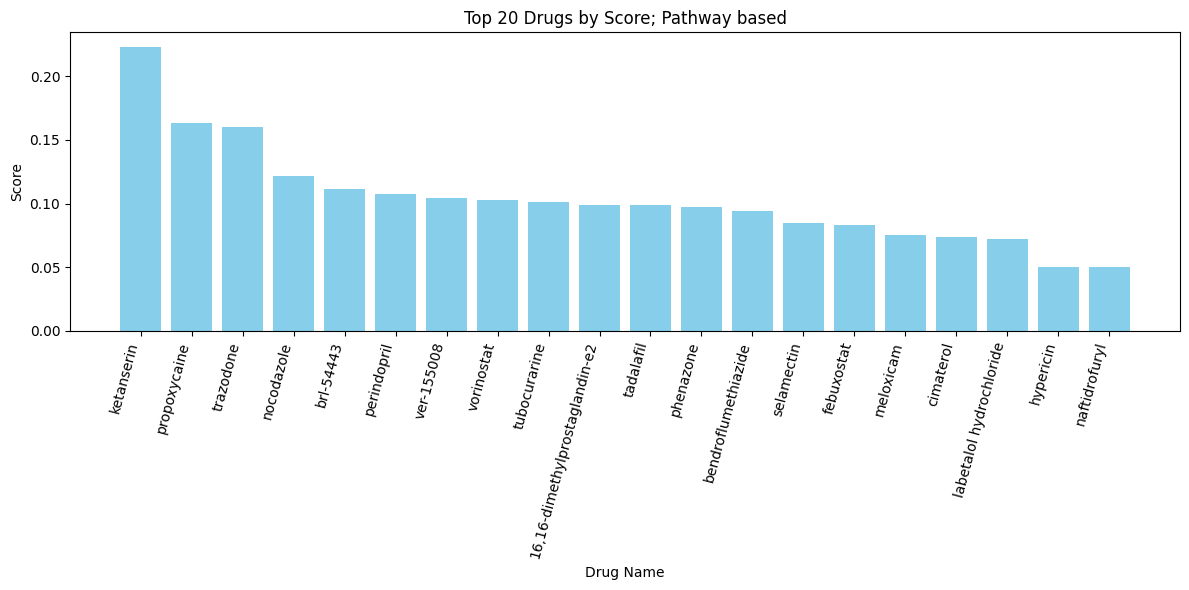

In [24]:
top20 = df_filtered.nlargest(20, 'score')
plt.figure(figsize=(12, 6))
plt.bar(top20['drug_name_mapped'], top20['score'], color='skyblue')
plt.xticks(rotation=75, ha='right')
plt.xlabel('Drug Name')
plt.ylabel('Score')
plt.title('Top 20 Drugs by Score; Pathway based')
plt.tight_layout()
plt.show()

In [25]:
# df_filtered[:20].drug_name_mapped.tolist()

In [26]:
df_filtered.drug_name_mapped.unique()

array(['ketanserin', 'propoxycaine', 'trazodone', ..., 'sulfaquinoxaline',
       'trichloroethylene', 'sulfaguanidine'], shape=(1858,), dtype=object)

In [27]:
df_filtered[df_filtered['brd_id_simplified'] == 'BRD-K49671696']

,drug_name,score,brd_id,brd_id_simplified,drug_name_mapped
3749,CPC002_HCC515_24H:BRD-K49671696-045-03-6:10,0.223152,BRD-K49671696-045-03-6,BRD-K49671696,ketanserin
42241,CPC016_MCF7_24H:BRD-K49671696-045-03-6:10,-0.220079,BRD-K49671696-045-03-6,BRD-K49671696,ketanserin
43322,CPC016_SKB_24H:BRD-K49671696-045-03-6:10,-0.319460,BRD-K49671696-045-03-6,BRD-K49671696,ketanserin
4331,CPC002_PC3_24H:BRD-K49671696-045-03-6:10,-0.322407,BRD-K49671696-045-03-6,BRD-K49671696,ketanserin
4910,CPC002_VCAP_24H:BRD-K49671696-045-03-6:10,-0.331661,BRD-K49671696-045-03-6,BRD-K49671696,ketanserin
40614,CPC016_A375_6H:BRD-K49671696-045-03-6:10,-0.338900,BRD-K49671696-045-03-6,BRD-K49671696,ketanserin
3168,CPC002_HA1E_24H:BRD-K49671696-045-03-6:10,-0.340638,BRD-K49671696-045-03-6,BRD-K49671696,ketanserin
52398,CPD001_PC3_24H:BRD-K49671696-347-03-6:10,-0.341593,BRD-K49671696-347-03-6,BRD-K49671696,ketanserin
42784,CPC016_NEU_24H:BRD-K49671696-045-03-6:10,-0.342454,BRD-K49671696-045-03-6,BRD-K49671696,ketanserin
43053,CPC016_NPC_24H:BRD-K49671696-045-03-6:10,-0.342940,BRD-K49671696-045-03-6,BRD-K49671696,ketanserin


In [28]:
df_filtered[:999].brd_id_simplified

3749     BRD-K49671696
42191    BRD-K18250272
10196    BRD-K70778732
10074    BRD-K12539581
42190    BRD-K17868609
             ...      
98510    BRD-A58955223
41560    BRD-A10420615
65512    BRD-K12343256
13548    BRD-A65145453
11338    BRD-K47192521
Name: brd_id_simplified, Length: 999, dtype: object

In [29]:
score_sharon = df_filtered.iloc[:999][['brd_id_simplified', 'score']]
score_sharon = score_sharon.drop_duplicates(subset='brd_id_simplified', keep='first')
print(score_sharon.head())

      brd_id_simplified     score
3749      BRD-K49671696  0.223152
42191     BRD-K18250272  0.163292
10196     BRD-K70778732  0.160246
10074     BRD-K12539581  0.121771
42190     BRD-K17868609  0.111020


In [30]:
score_sharon

,brd_id_simplified,score
3749,BRD-K49671696,0.223152
42191,BRD-K18250272,0.163292
10196,BRD-K70778732,0.160246
10074,BRD-K12539581,0.121771
42190,BRD-K17868609,0.111020
...,...,...
39562,BRD-A25143711,-0.303122
10471,BRD-K52075715,-0.303138
41560,BRD-A10420615,-0.303383
13548,BRD-A65145453,-0.303443


In [31]:
# drugscores = pd.read_csv("top_999_scores_vedika.csv", sep=",")
# drugscores['brd_id_simplified'] = drugscores['Well'].str.split('-').str[:2].str.join('-')
# drugscores = drugscores.drop_duplicates(subset='brd_id_simplified', keep='first')
# score_vedika = drugscores[["brd_id_simplified", "RestorationScore"]]
# print(score_vedika.head())

In [32]:
drugscores = pd.read_csv("top_drugs.csv", sep=",")
drugscores['brd_id_simplified'] = drugscores['Well'].str.split('-').str[:2].str.join('-')
drugscores = drugscores.drop_duplicates(subset='brd_id_simplified', keep='first')
score_vedika = drugscores[["brd_id_simplified", "RestorationScore"]]
print(score_vedika.head())

  brd_id_simplified  RestorationScore
0     BRD-A34817987          0.806962
1     BRD-K49671696          0.778192
2     BRD-K48367671          0.773285
3     BRD-K50398167          0.691024
4     BRD-K40578143          0.689708


In [33]:
drugscores['drug_name_mapped'] = drugscores['brd_id_simplified'].map(brd_map)
drugscores = drugscores[drugscores['drug_name_mapped'].notna()]
drugscores

,Compound,CellLine,Time,Well,RestorationScore,brd_id_simplified,drug_name_mapped
1,CPC002,HCC515,24H,BRD-K49671696-045-03-6,0.778192,BRD-K49671696,ketanserin
2,CPC002,HCC515,6H,BRD-K48367671-001-01-8,0.773285,BRD-K48367671,febuxostat
3,CPC018,HT29,6H,BRD-K50398167-236-12-8,0.691024,BRD-K50398167,meclofenamic-acid
4,CPC002,HCC515,24H,BRD-K40578143-001-01-8,0.689708,BRD-K40578143,gr-79236
5,NMH002,FIBRNPC,24H,BRD-K53263234-001-04-5,0.684642,BRD-K53263234,citco
...,...,...,...,...,...,...,...
990,CPC015,MCF7,24H,BRD-K57304726-003-03-6,-0.006989,BRD-K57304726,pre-084
991,CPC002,VCAP,6H,BRD-K54330070-001-07-1,-0.007243,BRD-K54330070,sb-202190
992,CPC005,HT29,24H,BRD-K66093087-001-02-3,-0.007330,BRD-K66093087,fgin-1-43
997,CPC004,HA1E,6H,BRD-A65671304-001-03-4,-0.007599,BRD-A65671304,candesartan-cilexetil


In [34]:
drugscores[['drug_name_mapped', 'RestorationScore', 'brd_id_simplified']]

,drug_name_mapped,RestorationScore,brd_id_simplified
1,ketanserin,0.778192,BRD-K49671696
2,febuxostat,0.773285,BRD-K48367671
3,meclofenamic-acid,0.691024,BRD-K50398167
4,gr-79236,0.689708,BRD-K40578143
5,citco,0.684642,BRD-K53263234
...,...,...,...
990,pre-084,-0.006989,BRD-K57304726
991,sb-202190,-0.007243,BRD-K54330070
992,fgin-1-43,-0.007330,BRD-K66093087
997,candesartan-cilexetil,-0.007599,BRD-A65671304


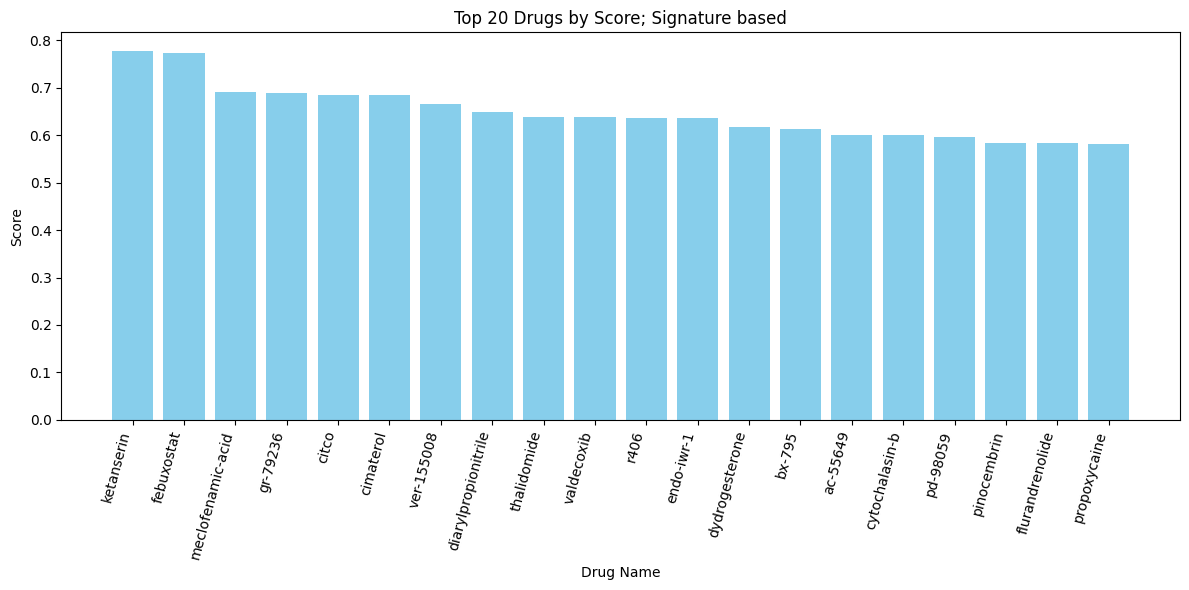

In [35]:

top20 = drugscores.nlargest(20, 'RestorationScore')
plt.figure(figsize=(12, 6))
plt.bar(top20['drug_name_mapped'], top20['RestorationScore'], color='skyblue')
plt.xticks(rotation=75, ha='right')
plt.xlabel('Drug Name')
plt.ylabel('Score')
plt.title('Top 20 Drugs by Score; Signature based')
plt.tight_layout()
plt.show()

In [36]:
merged_df = pd.merge(score_sharon, score_vedika, on='brd_id_simplified', how='inner')
merged_df

,brd_id_simplified,score,RestorationScore
0,BRD-K49671696,0.223152,0.778192
1,BRD-K18250272,0.163292,0.582613
2,BRD-K70778732,0.160246,0.316213
3,BRD-K12539581,0.121771,0.244490
4,BRD-K17868609,0.111020,0.043413
...,...,...,...
292,BRD-K02130563,-0.301891,0.066224
293,BRD-K92991072,-0.302418,0.178667
294,BRD-K50168500,-0.302740,0.312899
295,BRD-K28115081,-0.302921,0.027503


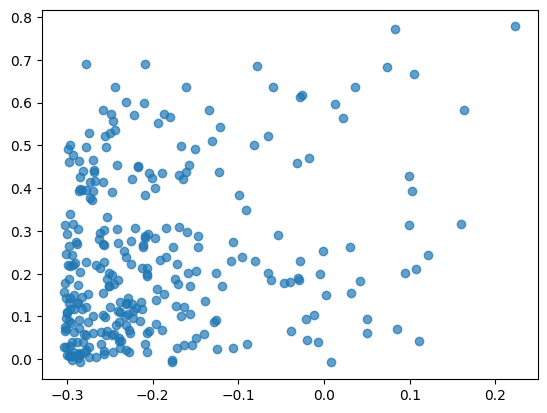

In [37]:
plt.scatter(merged_df['score'], merged_df['RestorationScore'], alpha=0.7)


In [38]:
score_vedika[:20].brd_id_simplified.map(brd_map).to_list()

[nan,
 'ketanserin',
 'febuxostat',
 'meclofenamic-acid',
 'gr-79236',
 'citco',
 'cimaterol',
 nan,
 'ver-155008',
 nan,
 'diarylpropionitrile',
 'thalidomide',
 'valdecoxib',
 'r406',
 'endo-iwr-1',
 'dydrogesterone',
 'bx-795',
 nan,
 'ac-55649',
 nan]

In [39]:
drug_restoration_scores_test_gnn = pd.read_csv("drug_restoration_scores_test_only.csv")

In [40]:
drug_restoration_scores_test_gnn['brd_id_simpliefied'] = drug_restoration_scores_test_gnn['drug'].str.split('_').str[0]

In [41]:
drug_restoration_scores_test_gnn['drug_name_mapped'] = drug_restoration_scores_test_gnn['brd_id_simpliefied'].map(brd_map)
drug_restoration_scores_test_gnn

,drug,restoration,off_target,score,dist_disease_healthy,dist_pred_healthy,dist_pred_disease,brd_id_simpliefied,drug_name_mapped
0,BRD-K55113501_avg,0.375947,0.492456,0.129719,1.318696,0.822937,0.492456,BRD-K55113501,NaN
1,BRD-K56751279_avg,0.375946,0.492512,0.129690,1.318696,0.822937,0.492512,BRD-K56751279,y-39983
2,BRD-K57080016_avg,0.375946,0.492555,0.129669,1.318696,0.822937,0.492555,BRD-K57080016,selumetinib
3,BRD-K49371609_avg,0.375946,0.492555,0.129669,1.318696,0.822937,0.492555,BRD-K49371609,pik-75
4,BRD-K38323065_avg,0.375946,0.492592,0.129650,1.318696,0.822938,0.492592,BRD-K38323065,phenacetin
5,BRD-A25143711_avg,0.375946,0.492592,0.129650,1.318696,0.822938,0.492592,BRD-A25143711,hydrocortisone valerate
6,BRD-A58207013_avg,0.375946,0.492592,0.129650,1.318696,0.822938,0.492592,BRD-A58207013,NaN
7,BRD-A84134924_avg,0.375946,0.492593,0.129650,1.318696,0.822938,0.492593,BRD-A84134924,NaN
8,BRD-K59197931_avg,0.375946,0.492601,0.129646,1.318696,0.822938,0.492601,BRD-K59197931,naproxen
9,BRD-A74975734_avg,0.375946,0.492642,0.129624,1.318696,0.822938,0.492642,BRD-A74975734,NaN


In [42]:
drug_restoration_scores_test_gnn = drug_restoration_scores_test_gnn.dropna(subset=['drug_name_mapped'])
drug_restoration_scores_test_gnn

,drug,restoration,off_target,score,dist_disease_healthy,dist_pred_healthy,dist_pred_disease,brd_id_simpliefied,drug_name_mapped
1,BRD-K56751279_avg,0.375946,0.492512,0.129690,1.318696,0.822937,0.492512,BRD-K56751279,y-39983
2,BRD-K57080016_avg,0.375946,0.492555,0.129669,1.318696,0.822937,0.492555,BRD-K57080016,selumetinib
3,BRD-K49371609_avg,0.375946,0.492555,0.129669,1.318696,0.822937,0.492555,BRD-K49371609,pik-75
4,BRD-K38323065_avg,0.375946,0.492592,0.129650,1.318696,0.822938,0.492592,BRD-K38323065,phenacetin
5,BRD-A25143711_avg,0.375946,0.492592,0.129650,1.318696,0.822938,0.492592,BRD-A25143711,hydrocortisone valerate
8,BRD-K59197931_avg,0.375946,0.492601,0.129646,1.318696,0.822938,0.492601,BRD-K59197931,naproxen


In [43]:
drug_restoration_scores_test_gnn

,drug,restoration,off_target,score,dist_disease_healthy,dist_pred_healthy,dist_pred_disease,brd_id_simpliefied,drug_name_mapped
1,BRD-K56751279_avg,0.375946,0.492512,0.129690,1.318696,0.822937,0.492512,BRD-K56751279,y-39983
2,BRD-K57080016_avg,0.375946,0.492555,0.129669,1.318696,0.822937,0.492555,BRD-K57080016,selumetinib
3,BRD-K49371609_avg,0.375946,0.492555,0.129669,1.318696,0.822937,0.492555,BRD-K49371609,pik-75
4,BRD-K38323065_avg,0.375946,0.492592,0.129650,1.318696,0.822938,0.492592,BRD-K38323065,phenacetin
5,BRD-A25143711_avg,0.375946,0.492592,0.129650,1.318696,0.822938,0.492592,BRD-A25143711,hydrocortisone valerate
8,BRD-K59197931_avg,0.375946,0.492601,0.129646,1.318696,0.822938,0.492601,BRD-K59197931,naproxen


In [44]:
drug_restoration_scores_test_gnn[['drug_name_mapped', 'score', 'brd_id_simpliefied']]

,drug_name_mapped,score,brd_id_simpliefied
1,y-39983,0.129690,BRD-K56751279
2,selumetinib,0.129669,BRD-K57080016
3,pik-75,0.129669,BRD-K49371609
4,phenacetin,0.129650,BRD-K38323065
5,hydrocortisone valerate,0.129650,BRD-A25143711
8,naproxen,0.129646,BRD-K59197931


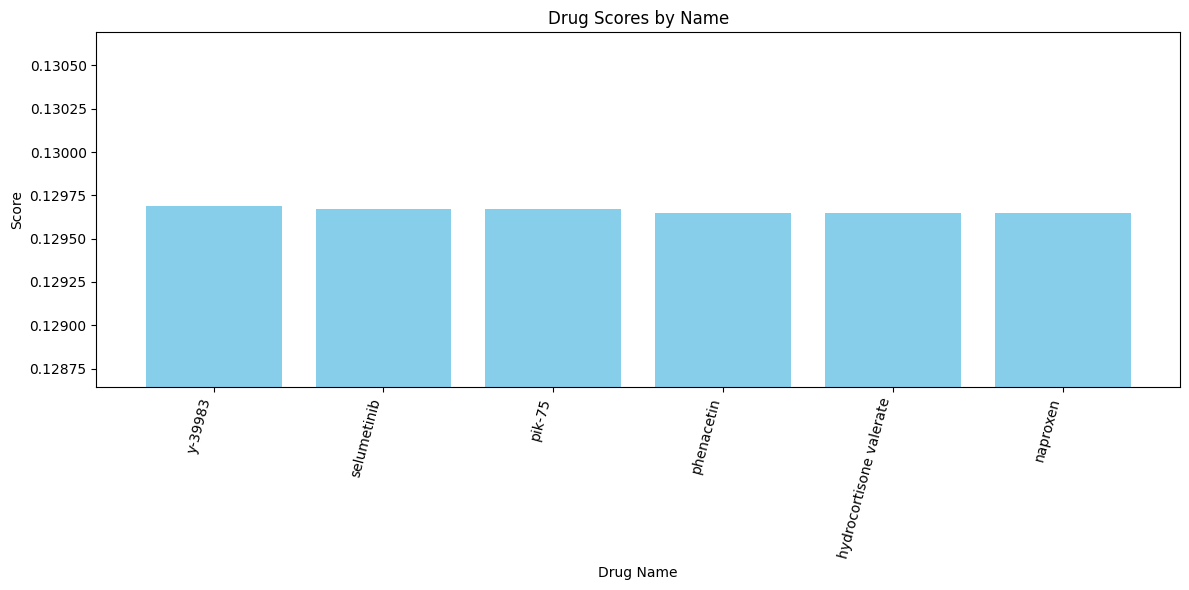

In [50]:
plt.figure(figsize=(12, 6))
plt.bar(drug_restoration_scores_test_gnn['drug_name_mapped'], drug_restoration_scores_test_gnn['score'], color='skyblue')
plt.ylim(
    drug_restoration_scores_test_gnn['score'].min() - 0.001, 
    drug_restoration_scores_test_gnn['score'].max() + 0.001
)
plt.xticks(rotation=75, ha='right')
plt.xlabel('Drug Name')
plt.ylabel('Score')
plt.title('Drug Scores by Name')
plt.tight_layout()
plt.show()

In [67]:

# drugscores.head(20).drug_name_mapped df_filtered.head(20).drug_name_mapped find interseciotn
set(drugscores.head(20).drug_name_mapped).intersection(set(df_filtered.head(20).drug_name_mapped))

{'cimaterol', 'febuxostat', 'ketanserin', 'propoxycaine', 'ver-155008'}